In [1]:
from data.dataset import ICDR2015Dataset
from models.model import DBNet
import matplotlib.pyplot as plt
import torch
from torch.nn import BCELoss, L1Loss
from data.dataloader import get_loaders
import cv2 as cv
from data.process.utils import resize_image

%load_ext autoreload
%autoreload 2

In [19]:
train_loader, val_loader = get_loaders('data', batch_size=1)

bin_loss_fn = BCELoss()
prob_loss_fn = BCELoss()
thresh_loss_fn = L1Loss()


def db_loss(pred, gt, train=True):
    if train:
        bin_loss = bin_loss_fn(pred["bin_map"], gt["bin_map"])
        print('bin -', bin_loss.item())
        prob_loss = prob_loss_fn(pred["prob_map"], gt["bin_map"])
        print('prob -', prob_loss.item())
        thresh_loss = thresh_loss_fn(pred["thresh_map"], gt["thresh_map"])
        print('thresh -', thresh_loss.item())
        loss = prob_loss + bin_loss + 10 * thresh_loss
        print('total -', loss.item())
    else:
        loss = 0
    return loss

[Epoch 343]
bin - 0.00831968616694212
prob - 0.003945729695260525
thresh - 0.0022707798052579165
total - 0.03497321158647537


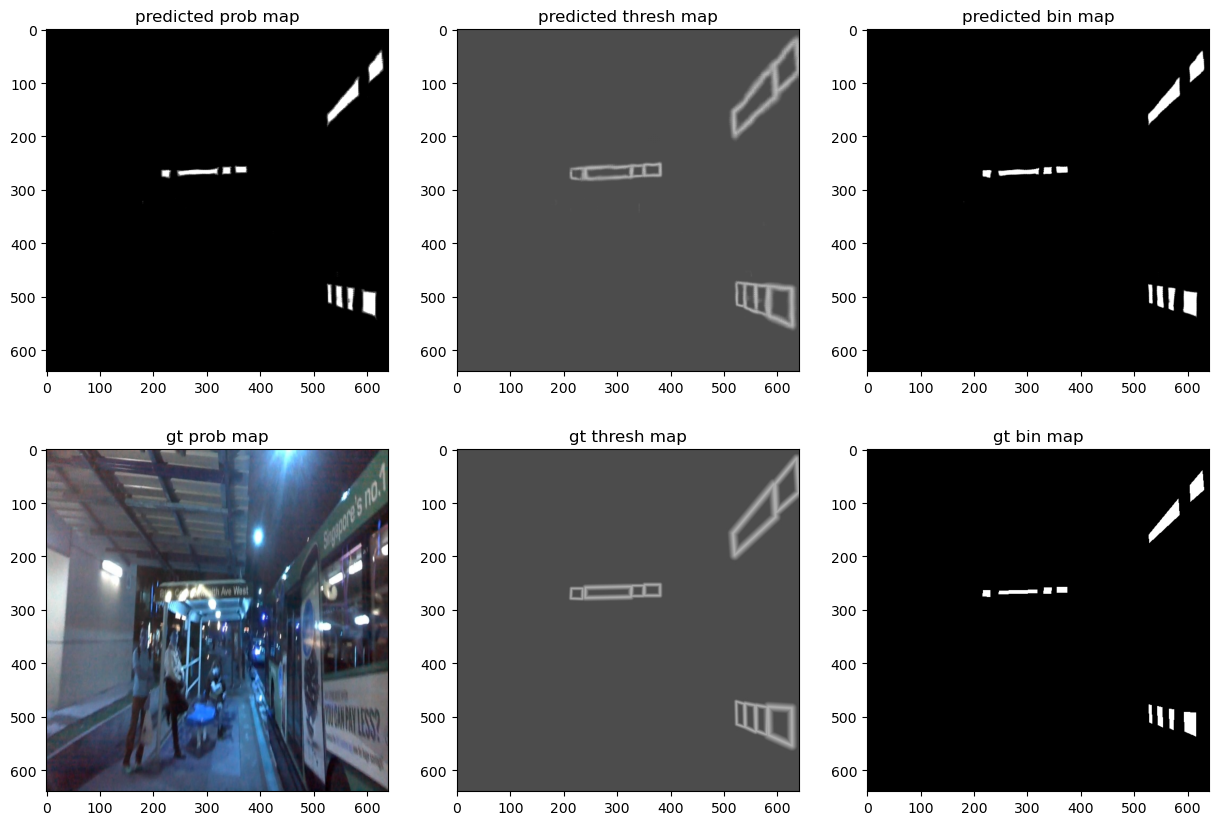

In [32]:
model = DBNet().cuda()
checkpoint = torch.load('models/checkpoints/dbnet_055', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f'[Epoch {checkpoint['epoch']}]')

dataset = ICDR2015Dataset('data')

img, maps = next(iter(train_loader))
img = img[0].permute(2, 0, 1).unsqueeze(0)
img = img.to(device='cuda', dtype=torch.float32)
img = (img - img.mean()) / img.std()
output = model(img)

for k, v in maps.items():
    maps[k] = v.to(device='cuda', dtype=torch.float32)
db_loss(output, maps)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].imshow(output['prob_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][0].set_title('predicted prob map')
axs[0][1].imshow(output['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][1].set_title('predicted thresh map')
axs[0][2].imshow(output['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][2].set_title('predicted bin map')

axs[1][0].imshow(((img - img.min()) / (img.max() - img.min()))[0].permute(1, 2, 0).detach().cpu())
axs[1][0].set_title('original image')
axs[1][1].imshow(maps['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title('gt thresh map')
axs[1][2].imshow(maps['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title('gt bin map')
plt.show()

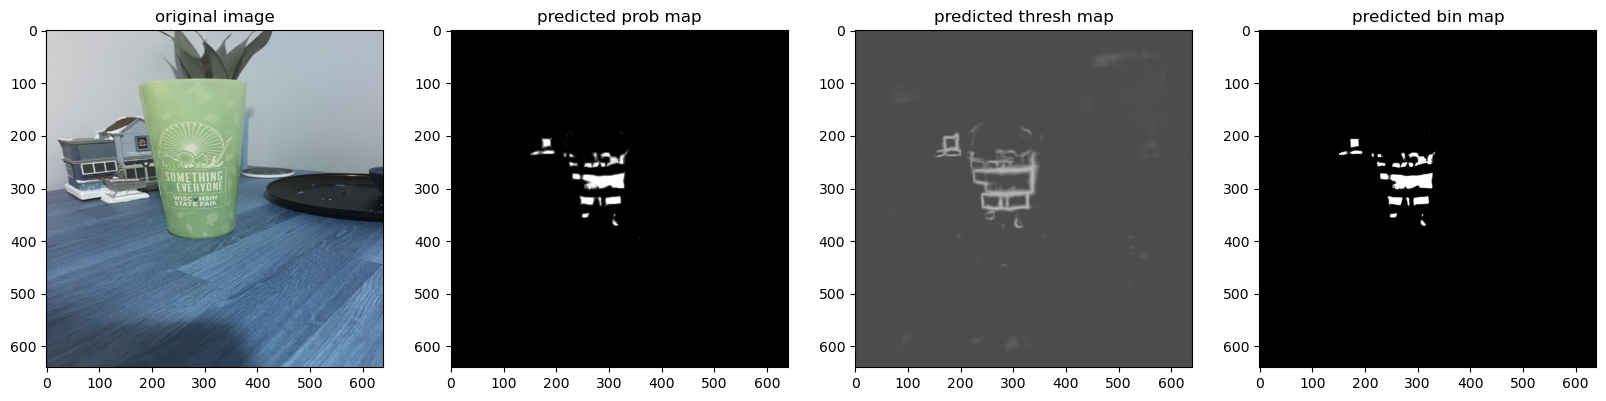

In [64]:
img = cv.imread('../rsz_image.jpg', cv.IMREAD_UNCHANGED) / 255
img = resize_image(img)
img = torch.from_numpy(img)
img = img.to(device='cuda', dtype=torch.float32)
output = model(img.permute(2, 0, 1).unsqueeze(0))

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(((img - img.min()) / (img.max() - img.min())).detach().cpu())
axs[0].set_title('original image')
axs[1].imshow(output['prob_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1].set_title('predicted prob map')
axs[2].imshow(output['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[2].set_title('predicted thresh map')
axs[3].imshow(output['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[3].set_title('predicted bin map')
plt.show()